# Char model

In [1]:
import numpy as np
from char_dataset import CharDataset
from char_model import CharRNN

## Dataset

In [3]:
dataset = CharDataset()
dataset.load('data/dostoevsky.txt')  # dostoevsky.txt  anna.txt
model_path = 'models/dostoevsky-001/'

## Build

In [4]:
num_layers  = 2
num_units   = 512
grad_clip   = 5.0

model = CharRNN(
    num_classes = len(dataset.vocab))

model.build(
    num_units  = num_units, 
    num_layers = num_layers, 
    grad_clip  = grad_clip)

## Train

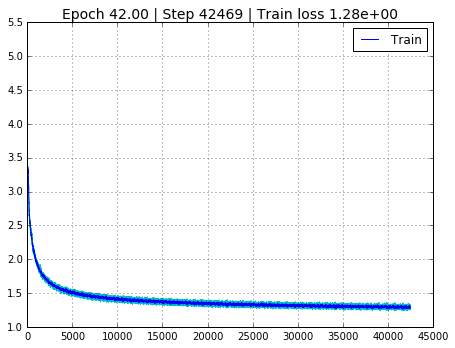

CPU times: user 41min 25s, sys: 5min 17s, total: 46min 42s
Wall time: 24min 7s


In [17]:
%%time
model.train(
    epochs        = 50, 
    batch_size    = 128, 
    seq_length    = 100,
    learning_rate = 1e-3, 
    keep_prob     = .5,
    dataset       = dataset)
model.save(model_path)

## Test

In [19]:
primes = ['МОК запретил российским олимпийцам использовать национальную символику']
for prime in primes:
    print('-'*50)
    samp = model.sample(dataset, n_samples=300, top_n=3, prime=prime)
    samp = samp.replace('\n', '\n\n')
    print(samp)

--------------------------------------------------
МОК запретил российским олимпийцам использовать национальную символику и страдал с советом, и, пожалуй, и с ними совсем не понимающий и совершенно на всех светели и привлекательные подозрения своего поставил на столько свойства, которые подле наших странных стариков просит себя принять. Вообще высоко случилось тогда в том, что в свете он представил его совершенно в то 


## Restore

In [5]:
model.restore(model_path)

INFO:tensorflow:Restoring parameters from models/dostoevsky-001/
